In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.6701 - acc: 0.1436
Epoch 00001: val_loss improved from inf to 2.53077, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/001-2.5308.hdf5
36805/36805 [==============================] - 31s 837us/sample - loss: 2.6698 - acc: 0.1436 - val_loss: 2.5308 - val_acc: 0.2409
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4727 - acc: 0.2048
Epoch 00002: val_loss improved from 2.53077 to 2.31038, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/002-2.3104.hdf5
36805/36805 [==============================] - 28s 753us/sample - loss: 2.4727 - acc: 0.2048 - val_loss: 2.3104 - val_acc: 0.3585
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3659 - acc: 0.2392
Epoch 00003: val_loss improved from 2

Epoch 22/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7160 - acc: 0.4512
Epoch 00022: val_loss improved from 1.52023 to 1.50841, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/022-1.5084.hdf5
36805/36805 [==============================] - 27s 743us/sample - loss: 1.7157 - acc: 0.4514 - val_loss: 1.5084 - val_acc: 0.5772
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7024 - acc: 0.4535
Epoch 00023: val_loss improved from 1.50841 to 1.48821, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/023-1.4882.hdf5
36805/36805 [==============================] - 27s 743us/sample - loss: 1.7024 - acc: 0.4535 - val_loss: 1.4882 - val_acc: 0.5872
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6926 - acc: 0.4608
Epoch 00024: val_loss did not improve from 1.48821
36805/36805 [==============================] - 27s 741us/sample - loss: 1.69

Epoch 46/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5229 - acc: 0.5172
Epoch 00046: val_loss did not improve from 1.28688
36805/36805 [==============================] - 27s 740us/sample - loss: 1.5229 - acc: 0.5172 - val_loss: 1.4315 - val_acc: 0.5360
Epoch 47/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5165 - acc: 0.5171
Epoch 00047: val_loss improved from 1.28688 to 1.27106, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/047-1.2711.hdf5
36805/36805 [==============================] - 27s 741us/sample - loss: 1.5164 - acc: 0.5171 - val_loss: 1.2711 - val_acc: 0.6564
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5147 - acc: 0.5198
Epoch 00048: val_loss improved from 1.27106 to 1.26067, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/048-1.2607.hdf5
36805/36805 [==============================] - 27s 742us/sample - loss: 1.51

Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4288 - acc: 0.5506
Epoch 00072: val_loss improved from 1.18879 to 1.16473, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/072-1.1647.hdf5
36805/36805 [==============================] - 27s 743us/sample - loss: 1.4284 - acc: 0.5506 - val_loss: 1.1647 - val_acc: 0.6692
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4192 - acc: 0.5485
Epoch 00073: val_loss did not improve from 1.16473
36805/36805 [==============================] - 27s 737us/sample - loss: 1.4192 - acc: 0.5485 - val_loss: 1.2125 - val_acc: 0.6499
Epoch 74/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4178 - acc: 0.5533
Epoch 00074: val_loss did not improve from 1.16473
36805/36805 [==============================] - 27s 741us/sample - loss: 1.4173 - acc: 0.5535 - val_loss: 1.2069 - val_acc: 0.6511
Epoch 75/500
36736/36805 [============================>.

Epoch 98/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3526 - acc: 0.5713
Epoch 00098: val_loss did not improve from 1.10335
36805/36805 [==============================] - 27s 741us/sample - loss: 1.3533 - acc: 0.5711 - val_loss: 1.1123 - val_acc: 0.6860
Epoch 99/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3577 - acc: 0.5758
Epoch 00099: val_loss improved from 1.10335 to 1.09051, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/099-1.0905.hdf5
36805/36805 [==============================] - 27s 743us/sample - loss: 1.3582 - acc: 0.5758 - val_loss: 1.0905 - val_acc: 0.6932
Epoch 100/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3533 - acc: 0.5756
Epoch 00100: val_loss did not improve from 1.09051
36805/36805 [==============================] - 27s 740us/sample - loss: 1.3539 - acc: 0.5753 - val_loss: 1.1173 - val_acc: 0.6816
Epoch 101/500
36800/36805 [============================

36736/36805 [============================>.] - ETA: 0s - loss: 1.3073 - acc: 0.5915
Epoch 00124: val_loss did not improve from 1.04151
36805/36805 [==============================] - 27s 742us/sample - loss: 1.3072 - acc: 0.5915 - val_loss: 2.2859 - val_acc: 0.4016
Epoch 125/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3056 - acc: 0.5868
Epoch 00125: val_loss did not improve from 1.04151
36805/36805 [==============================] - 27s 740us/sample - loss: 1.3056 - acc: 0.5866 - val_loss: 1.0781 - val_acc: 0.6811
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3037 - acc: 0.5910
Epoch 00126: val_loss did not improve from 1.04151
36805/36805 [==============================] - 27s 737us/sample - loss: 1.3037 - acc: 0.5910 - val_loss: 1.0546 - val_acc: 0.6942
Epoch 127/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2992 - acc: 0.5932
Epoch 00127: val_loss did not improve from 1.04151
36805/36805 [===============

Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2640 - acc: 0.6004
Epoch 00152: val_loss did not improve from 1.00473
36805/36805 [==============================] - 27s 739us/sample - loss: 1.2641 - acc: 0.6004 - val_loss: 1.0270 - val_acc: 0.7077
Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2688 - acc: 0.6052
Epoch 00153: val_loss did not improve from 1.00473
36805/36805 [==============================] - 27s 743us/sample - loss: 1.2690 - acc: 0.6052 - val_loss: 1.3110 - val_acc: 0.5835
Epoch 154/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2658 - acc: 0.6052
Epoch 00154: val_loss did not improve from 1.00473
36805/36805 [==============================] - 27s 739us/sample - loss: 1.2662 - acc: 0.6052 - val_loss: 1.2534 - val_acc: 0.5991
Epoch 155/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2584 - acc: 0.6048
Epoch 00155: val_loss did not improve from 1.00473
36805/36805 [=

Epoch 181/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2394 - acc: 0.6115
Epoch 00181: val_loss did not improve from 0.97881
36805/36805 [==============================] - 27s 736us/sample - loss: 1.2393 - acc: 0.6114 - val_loss: 1.0265 - val_acc: 0.7077
Epoch 182/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2319 - acc: 0.6157
Epoch 00182: val_loss did not improve from 0.97881
36805/36805 [==============================] - 27s 735us/sample - loss: 1.2324 - acc: 0.6157 - val_loss: 1.8166 - val_acc: 0.4754
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2331 - acc: 0.6179
Epoch 00183: val_loss did not improve from 0.97881
36805/36805 [==============================] - 27s 742us/sample - loss: 1.2331 - acc: 0.6179 - val_loss: 1.0047 - val_acc: 0.7188
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2340 - acc: 0.6158
Epoch 00184: val_loss did not improve from 0.97881
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 1.2127 - acc: 0.6226
Epoch 00209: val_loss improved from 0.95498 to 0.92995, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/209-0.9299.hdf5
36805/36805 [==============================] - 27s 739us/sample - loss: 1.2128 - acc: 0.6226 - val_loss: 0.9299 - val_acc: 0.7407
Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2071 - acc: 0.6246
Epoch 00210: val_loss did not improve from 0.92995
36805/36805 [==============================] - 27s 742us/sample - loss: 1.2071 - acc: 0.6246 - val_loss: 0.9739 - val_acc: 0.7088
Epoch 211/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2063 - acc: 0.6227
Epoch 00211: val_loss did not improve from 0.92995
36805/36805 [==============================] - 27s 739us/sample - loss: 1.2059 - acc: 0.6228 - val_loss: 0.9330 - val_acc: 0.7424
Epoch 212/500
36736/36805 [============================>.] - ETA: 0

Epoch 238/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1870 - acc: 0.6283
Epoch 00238: val_loss did not improve from 0.92487
36805/36805 [==============================] - 27s 740us/sample - loss: 1.1873 - acc: 0.6284 - val_loss: 0.9611 - val_acc: 0.7272
Epoch 239/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1858 - acc: 0.6310
Epoch 00239: val_loss did not improve from 0.92487
36805/36805 [==============================] - 27s 739us/sample - loss: 1.1857 - acc: 0.6310 - val_loss: 0.9355 - val_acc: 0.7365
Epoch 240/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1824 - acc: 0.6334
Epoch 00240: val_loss did not improve from 0.92487
36805/36805 [==============================] - 27s 741us/sample - loss: 1.1830 - acc: 0.6331 - val_loss: 0.9626 - val_acc: 0.7235
Epoch 241/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1829 - acc: 0.6325
Epoch 00241: val_loss did not improve from 0.92487
36805/36805 [=

Epoch 267/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1638 - acc: 0.6364
Epoch 00267: val_loss did not improve from 0.90310
36805/36805 [==============================] - 27s 740us/sample - loss: 1.1633 - acc: 0.6366 - val_loss: 0.9703 - val_acc: 0.7230
Epoch 268/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1730 - acc: 0.6365
Epoch 00268: val_loss did not improve from 0.90310
36805/36805 [==============================] - 27s 739us/sample - loss: 1.1730 - acc: 0.6365 - val_loss: 1.1054 - val_acc: 0.6522
Epoch 269/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1726 - acc: 0.6353
Epoch 00269: val_loss did not improve from 0.90310
36805/36805 [==============================] - 27s 742us/sample - loss: 1.1724 - acc: 0.6353 - val_loss: 0.9293 - val_acc: 0.7289
Epoch 270/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1704 - acc: 0.6363
Epoch 00270: val_loss did not improve from 0.90310
36805/36805 [=

Epoch 297/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1551 - acc: 0.6410
Epoch 00297: val_loss did not improve from 0.88332
36805/36805 [==============================] - 27s 740us/sample - loss: 1.1552 - acc: 0.6410 - val_loss: 1.0373 - val_acc: 0.6625
Epoch 298/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1499 - acc: 0.6447
Epoch 00298: val_loss did not improve from 0.88332
36805/36805 [==============================] - 27s 739us/sample - loss: 1.1497 - acc: 0.6448 - val_loss: 0.9396 - val_acc: 0.7319
Epoch 299/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1499 - acc: 0.6436
Epoch 00299: val_loss did not improve from 0.88332
36805/36805 [==============================] - 27s 740us/sample - loss: 1.1496 - acc: 0.6438 - val_loss: 1.0359 - val_acc: 0.6965
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1505 - acc: 0.6432
Epoch 00300: val_loss did not improve from 0.88332
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 1.1427 - acc: 0.6451
Epoch 00325: val_loss did not improve from 0.87094
36805/36805 [==============================] - 27s 741us/sample - loss: 1.1420 - acc: 0.6454 - val_loss: 0.8838 - val_acc: 0.7536
Epoch 326/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1387 - acc: 0.6471
Epoch 00326: val_loss did not improve from 0.87094
36805/36805 [==============================] - 27s 739us/sample - loss: 1.1389 - acc: 0.6470 - val_loss: 0.9165 - val_acc: 0.7361
Epoch 327/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1393 - acc: 0.6471
Epoch 00327: val_loss did not improve from 0.87094
36805/36805 [==============================] - 27s 742us/sample - loss: 1.1389 - acc: 0.6471 - val_loss: 0.9242 - val_acc: 0.7293
Epoch 328/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1359 - acc: 0.6485
Epoch 00328: val_loss did not improve from 0.87094
36805/36805 [===============

Epoch 354/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1226 - acc: 0.6533
Epoch 00354: val_loss did not improve from 0.86900
36805/36805 [==============================] - 27s 739us/sample - loss: 1.1230 - acc: 0.6533 - val_loss: 2.6948 - val_acc: 0.3652
Epoch 355/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1286 - acc: 0.6505
Epoch 00355: val_loss improved from 0.86900 to 0.86199, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/355-0.8620.hdf5
36805/36805 [==============================] - 27s 742us/sample - loss: 1.1281 - acc: 0.6507 - val_loss: 0.8620 - val_acc: 0.7617
Epoch 356/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1240 - acc: 0.6537
Epoch 00356: val_loss did not improve from 0.86199
36805/36805 [==============================] - 27s 739us/sample - loss: 1.1243 - acc: 0.6537 - val_loss: 1.1891 - val_acc: 0.6159
Epoch 357/500
36736/36805 [==========================

Epoch 383/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1177 - acc: 0.6546
Epoch 00383: val_loss did not improve from 0.85774
36805/36805 [==============================] - 27s 741us/sample - loss: 1.1173 - acc: 0.6547 - val_loss: 0.8659 - val_acc: 0.7510
Epoch 384/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1156 - acc: 0.6557
Epoch 00384: val_loss did not improve from 0.85774
36805/36805 [==============================] - 27s 740us/sample - loss: 1.1153 - acc: 0.6556 - val_loss: 0.8599 - val_acc: 0.7624
Epoch 385/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1152 - acc: 0.6570
Epoch 00385: val_loss did not improve from 0.85774
36805/36805 [==============================] - 27s 736us/sample - loss: 1.1153 - acc: 0.6570 - val_loss: 0.8924 - val_acc: 0.7519
Epoch 386/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1159 - acc: 0.6540
Epoch 00386: val_loss did not improve from 0.85774
36805/36805 [=

Epoch 412/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1100 - acc: 0.6587
Epoch 00412: val_loss did not improve from 0.84097
36805/36805 [==============================] - 27s 738us/sample - loss: 1.1100 - acc: 0.6587 - val_loss: 0.8843 - val_acc: 0.7498
Epoch 413/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1041 - acc: 0.6577
Epoch 00413: val_loss did not improve from 0.84097
36805/36805 [==============================] - 27s 740us/sample - loss: 1.1041 - acc: 0.6577 - val_loss: 1.7090 - val_acc: 0.5059
Epoch 414/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1027 - acc: 0.6593
Epoch 00414: val_loss did not improve from 0.84097
36805/36805 [==============================] - 27s 740us/sample - loss: 1.1026 - acc: 0.6592 - val_loss: 0.9046 - val_acc: 0.7384
Epoch 415/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1014 - acc: 0.6573
Epoch 00415: val_loss did not improve from 0.84097
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 1.0949 - acc: 0.6626
Epoch 00440: val_loss did not improve from 0.83081
36805/36805 [==============================] - 27s 740us/sample - loss: 1.0950 - acc: 0.6625 - val_loss: 1.2786 - val_acc: 0.6105
Epoch 441/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0936 - acc: 0.6613
Epoch 00441: val_loss improved from 0.83081 to 0.82987, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv_checkpoint/441-0.8299.hdf5
36805/36805 [==============================] - 27s 743us/sample - loss: 1.0937 - acc: 0.6614 - val_loss: 0.8299 - val_acc: 0.7768
Epoch 442/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0970 - acc: 0.6630
Epoch 00442: val_loss did not improve from 0.82987
36805/36805 [==============================] - 27s 739us/sample - loss: 1.0974 - acc: 0.6629 - val_loss: 0.9512 - val_acc: 0.6988
Epoch 443/500
36736/36805 [============================>.] - ETA: 0

Epoch 469/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0875 - acc: 0.6651
Epoch 00469: val_loss did not improve from 0.82945
36805/36805 [==============================] - 27s 738us/sample - loss: 1.0875 - acc: 0.6652 - val_loss: 0.8543 - val_acc: 0.7647
Epoch 470/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0842 - acc: 0.6643
Epoch 00470: val_loss did not improve from 0.82945
36805/36805 [==============================] - 27s 740us/sample - loss: 1.0838 - acc: 0.6645 - val_loss: 0.8944 - val_acc: 0.7412
Epoch 471/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0891 - acc: 0.6633
Epoch 00471: val_loss did not improve from 0.82945
36805/36805 [==============================] - 27s 741us/sample - loss: 1.0892 - acc: 0.6633 - val_loss: 0.8963 - val_acc: 0.7449
Epoch 472/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0814 - acc: 0.6623
Epoch 00472: val_loss did not improve from 0.82945
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 1.0745 - acc: 0.6695
Epoch 00497: val_loss did not improve from 0.81536
36805/36805 [==============================] - 27s 737us/sample - loss: 1.0744 - acc: 0.6695 - val_loss: 0.8606 - val_acc: 0.7549
Epoch 498/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0790 - acc: 0.6655
Epoch 00498: val_loss did not improve from 0.81536
36805/36805 [==============================] - 27s 736us/sample - loss: 1.0792 - acc: 0.6655 - val_loss: 0.8384 - val_acc: 0.7694
Epoch 499/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0769 - acc: 0.6675
Epoch 00499: val_loss did not improve from 0.81536
36805/36805 [==============================] - 27s 738us/sample - loss: 1.0770 - acc: 0.6674 - val_loss: 0.8302 - val_acc: 0.7682
Epoch 500/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0831 - acc: 0.6676
Epoch 00500: val_loss did not improve from 0.81536
36805/36805 [===============

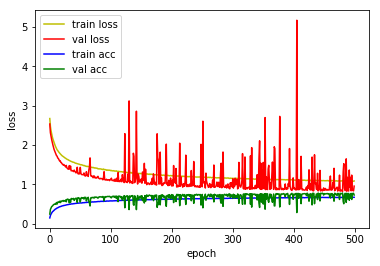

4815/4815 [==============================] - 2s 389us/sample - loss: 0.8598 - acc: 0.7466
Loss: 0.8598382489455947 Accuracy: 0.7466251

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.6535 - acc: 0.1496
Epoch 00001: val_loss improved from inf to 2.44409, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/001-2.4441.hdf5
36805/36805 [==============================] - 32s 857us/sample - loss: 2.6531 - acc: 0.1498 - val_loss: 2.4441 - val_acc: 0.3040
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3406 - acc: 0.2442
Epoch 00002: val_loss improved from 2.44409 to 2.12482, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/002-2.1248.hdf5
36805/36805 [==============================] - 28s 765us/sample - loss: 2.3403 - acc: 0.2442 - val_loss: 2.1248 - val_acc: 0.4118
Epoch 3/500
36800/36805 [====================

36736/36805 [============================>.] - ETA: 0s - loss: 1.3799 - acc: 0.5675
Epoch 00022: val_loss did not improve from 1.18601
36805/36805 [==============================] - 28s 770us/sample - loss: 1.3801 - acc: 0.5674 - val_loss: 1.2539 - val_acc: 0.6184
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3575 - acc: 0.5773
Epoch 00023: val_loss improved from 1.18601 to 1.09972, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/023-1.0997.hdf5
36805/36805 [==============================] - 28s 769us/sample - loss: 1.3574 - acc: 0.5773 - val_loss: 1.0997 - val_acc: 0.7028
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3479 - acc: 0.5798
Epoch 00024: val_loss did not improve from 1.09972
36805/36805 [==============================] - 28s 760us/sample - loss: 1.3477 - acc: 0.5799 - val_loss: 1.1019 - val_acc: 0.6958
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s -

Epoch 47/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1523 - acc: 0.6457
Epoch 00047: val_loss improved from 0.91307 to 0.88678, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/047-0.8868.hdf5
36805/36805 [==============================] - 28s 760us/sample - loss: 1.1523 - acc: 0.6456 - val_loss: 0.8868 - val_acc: 0.7563
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1425 - acc: 0.6498
Epoch 00048: val_loss did not improve from 0.88678
36805/36805 [==============================] - 28s 758us/sample - loss: 1.1424 - acc: 0.6498 - val_loss: 0.8872 - val_acc: 0.7675
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1337 - acc: 0.6520
Epoch 00049: val_loss improved from 0.88678 to 0.88180, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/049-0.8818.hdf5
36805/36805 [==============================] - 28s 761us/sample - loss: 1.13

Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0438 - acc: 0.6821
Epoch 00072: val_loss did not improve from 0.79985
36805/36805 [==============================] - 28s 754us/sample - loss: 1.0441 - acc: 0.6820 - val_loss: 0.8151 - val_acc: 0.7822
Epoch 73/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0418 - acc: 0.6825
Epoch 00073: val_loss did not improve from 0.79985
36805/36805 [==============================] - 28s 762us/sample - loss: 1.0424 - acc: 0.6824 - val_loss: 0.8087 - val_acc: 0.7845
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0416 - acc: 0.6816
Epoch 00074: val_loss did not improve from 0.79985
36805/36805 [==============================] - 28s 763us/sample - loss: 1.0416 - acc: 0.6816 - val_loss: 0.8141 - val_acc: 0.7734
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0349 - acc: 0.6847
Epoch 00075: val_loss did not improve from 0.79985
36805/36805 [=====

36736/36805 [============================>.] - ETA: 0s - loss: 0.9809 - acc: 0.7021
Epoch 00099: val_loss did not improve from 0.73937
36805/36805 [==============================] - 28s 766us/sample - loss: 0.9806 - acc: 0.7023 - val_loss: 0.8112 - val_acc: 0.7650
Epoch 100/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9819 - acc: 0.7016
Epoch 00100: val_loss did not improve from 0.73937
36805/36805 [==============================] - 28s 756us/sample - loss: 0.9824 - acc: 0.7014 - val_loss: 0.7894 - val_acc: 0.7734
Epoch 101/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9754 - acc: 0.7054
Epoch 00101: val_loss did not improve from 0.73937
36805/36805 [==============================] - 28s 766us/sample - loss: 0.9753 - acc: 0.7054 - val_loss: 0.8140 - val_acc: 0.7622
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9800 - acc: 0.7009
Epoch 00102: val_loss improved from 0.73937 to 0.73761, saving model to model/c

Epoch 127/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9380 - acc: 0.7172
Epoch 00127: val_loss improved from 0.70885 to 0.70684, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/127-0.7068.hdf5
36805/36805 [==============================] - 28s 762us/sample - loss: 0.9380 - acc: 0.7171 - val_loss: 0.7068 - val_acc: 0.8123
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9283 - acc: 0.7175
Epoch 00128: val_loss improved from 0.70684 to 0.69811, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/128-0.6981.hdf5
36805/36805 [==============================] - 28s 768us/sample - loss: 0.9283 - acc: 0.7175 - val_loss: 0.6981 - val_acc: 0.8146
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9327 - acc: 0.7173
Epoch 00129: val_loss did not improve from 0.69811
36805/36805 [==============================] - 28s 761us/sample - loss: 0

Epoch 155/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8967 - acc: 0.7285
Epoch 00155: val_loss did not improve from 0.67940
36805/36805 [==============================] - 28s 759us/sample - loss: 0.8972 - acc: 0.7284 - val_loss: 0.7015 - val_acc: 0.8130
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8975 - acc: 0.7283
Epoch 00156: val_loss did not improve from 0.67940
36805/36805 [==============================] - 28s 764us/sample - loss: 0.8975 - acc: 0.7283 - val_loss: 0.6949 - val_acc: 0.8213
Epoch 157/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8925 - acc: 0.7302
Epoch 00157: val_loss did not improve from 0.67940
36805/36805 [==============================] - 28s 765us/sample - loss: 0.8925 - acc: 0.7301 - val_loss: 0.6886 - val_acc: 0.8113
Epoch 158/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8978 - acc: 0.7280
Epoch 00158: val_loss did not improve from 0.67940
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.8752 - acc: 0.7337
Epoch 00183: val_loss did not improve from 0.65673
36805/36805 [==============================] - 28s 763us/sample - loss: 0.8754 - acc: 0.7337 - val_loss: 0.8952 - val_acc: 0.7142
Epoch 184/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8776 - acc: 0.7340
Epoch 00184: val_loss did not improve from 0.65673
36805/36805 [==============================] - 28s 765us/sample - loss: 0.8779 - acc: 0.7339 - val_loss: 0.6576 - val_acc: 0.8248
Epoch 185/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8732 - acc: 0.7334
Epoch 00185: val_loss did not improve from 0.65673
36805/36805 [==============================] - 28s 763us/sample - loss: 0.8735 - acc: 0.7334 - val_loss: 0.7496 - val_acc: 0.7915
Epoch 186/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8701 - acc: 0.7351
Epoch 00186: val_loss did not improve from 0.65673
36805/36805 [===============

Epoch 212/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8564 - acc: 0.7390
Epoch 00212: val_loss did not improve from 0.63734
36805/36805 [==============================] - 28s 760us/sample - loss: 0.8564 - acc: 0.7390 - val_loss: 0.7631 - val_acc: 0.7759
Epoch 213/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8505 - acc: 0.7403
Epoch 00213: val_loss did not improve from 0.63734
36805/36805 [==============================] - 28s 762us/sample - loss: 0.8506 - acc: 0.7403 - val_loss: 0.9004 - val_acc: 0.7130
Epoch 214/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8491 - acc: 0.7433
Epoch 00214: val_loss improved from 0.63734 to 0.63011, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_4_conv_checkpoint/214-0.6301.hdf5
36805/36805 [==============================] - 28s 766us/sample - loss: 0.8490 - acc: 0.7432 - val_loss: 0.6301 - val_acc: 0.8334
Epoch 215/500
36800/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.8408 - acc: 0.7464
Epoch 00240: val_loss did not improve from 0.62147
36805/36805 [==============================] - 28s 765us/sample - loss: 0.8407 - acc: 0.7464 - val_loss: 0.8102 - val_acc: 0.7598
Epoch 241/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8342 - acc: 0.7460
Epoch 00241: val_loss did not improve from 0.62147
36805/36805 [==============================] - 28s 764us/sample - loss: 0.8342 - acc: 0.7460 - val_loss: 0.9019 - val_acc: 0.7214
Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8279 - acc: 0.7464
Epoch 00242: val_loss did not improve from 0.62147
36805/36805 [==============================] - 28s 765us/sample - loss: 0.8278 - acc: 0.7465 - val_loss: 0.6454 - val_acc: 0.8279
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8257 - acc: 0.7483
Epoch 00243: val_loss did not improve from 0.62147
36805/36805 [===============

Epoch 269/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8219 - acc: 0.7497
Epoch 00269: val_loss did not improve from 0.61316
36805/36805 [==============================] - 28s 773us/sample - loss: 0.8219 - acc: 0.7497 - val_loss: 0.6561 - val_acc: 0.8241
Epoch 270/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8192 - acc: 0.7521
Epoch 00270: val_loss did not improve from 0.61316
36805/36805 [==============================] - 28s 765us/sample - loss: 0.8190 - acc: 0.7520 - val_loss: 0.6226 - val_acc: 0.8351
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8182 - acc: 0.7523
Epoch 00271: val_loss did not improve from 0.61316
36805/36805 [==============================] - 28s 768us/sample - loss: 0.8183 - acc: 0.7523 - val_loss: 0.6288 - val_acc: 0.8314
Epoch 272/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8199 - acc: 0.7506
Epoch 00272: val_loss did not improve from 0.61316
36805/36805 [=

Epoch 298/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8047 - acc: 0.7552
Epoch 00298: val_loss did not improve from 0.60647
36805/36805 [==============================] - 28s 763us/sample - loss: 0.8047 - acc: 0.7552 - val_loss: 0.6754 - val_acc: 0.8074
Epoch 299/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8005 - acc: 0.7570
Epoch 00299: val_loss did not improve from 0.60647
36805/36805 [==============================] - 28s 761us/sample - loss: 0.8008 - acc: 0.7569 - val_loss: 0.6297 - val_acc: 0.8286
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8124 - acc: 0.7540
Epoch 00300: val_loss did not improve from 0.60647
36805/36805 [==============================] - 28s 766us/sample - loss: 0.8126 - acc: 0.7539 - val_loss: 0.6522 - val_acc: 0.8178
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8064 - acc: 0.7567
Epoch 00301: val_loss did not improve from 0.60647
36805/36805 [=

Epoch 327/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7900 - acc: 0.7577
Epoch 00327: val_loss did not improve from 0.58823
36805/36805 [==============================] - 28s 766us/sample - loss: 0.7900 - acc: 0.7577 - val_loss: 0.6144 - val_acc: 0.8358
Epoch 328/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7893 - acc: 0.7612
Epoch 00328: val_loss did not improve from 0.58823
36805/36805 [==============================] - 28s 767us/sample - loss: 0.7892 - acc: 0.7612 - val_loss: 0.6460 - val_acc: 0.8204
Epoch 329/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7932 - acc: 0.7575
Epoch 00329: val_loss did not improve from 0.58823
36805/36805 [==============================] - 28s 767us/sample - loss: 0.7933 - acc: 0.7575 - val_loss: 0.5950 - val_acc: 0.8414
Epoch 330/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7917 - acc: 0.7597
Epoch 00330: val_loss did not improve from 0.58823
36805/36805 [=

Epoch 357/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7842 - acc: 0.7618
Epoch 00357: val_loss did not improve from 0.58823
36805/36805 [==============================] - 28s 764us/sample - loss: 0.7842 - acc: 0.7618 - val_loss: 0.5885 - val_acc: 0.8421
Epoch 358/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7792 - acc: 0.7629
Epoch 00358: val_loss did not improve from 0.58823
36805/36805 [==============================] - 28s 766us/sample - loss: 0.7792 - acc: 0.7629 - val_loss: 0.6315 - val_acc: 0.8265
Epoch 359/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7776 - acc: 0.7660
Epoch 00359: val_loss did not improve from 0.58823
36805/36805 [==============================] - 28s 769us/sample - loss: 0.7776 - acc: 0.7659 - val_loss: 0.7544 - val_acc: 0.7782
Epoch 360/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7808 - acc: 0.7624
Epoch 00360: val_loss did not improve from 0.58823
36805/36805 [=

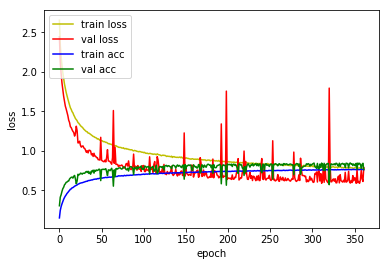

4815/4815 [==============================] - 2s 397us/sample - loss: 0.6458 - acc: 0.8083
Loss: 0.6457661219227475 Accuracy: 0.80830735

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5002 - acc: 0.2086
Epoch 00001: val_loss improved from inf to 2.25048, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv_checkpoint/001-2.2505.hdf5
36805/36805 [==============================] - 35s 961us/sample - loss: 2.5001 - acc: 0.2086 - val_loss: 2.2505 - val_acc: 0.3422
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1004 - acc: 0.3268
Epoch 00002: val_loss improved from 2.25048 to 1.79026, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv_checkpoint/002-1.7903.hdf5
36805/36805 [==============================] - 30s 807us/sample - loss: 2.1004 - acc: 0.3268 - val_loss: 1.7903 - val_acc: 0.5064
Epoch 3/500
36800/36805 [===================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9810 - acc: 0.7033
Epoch 00024: val_loss improved from 0.78765 to 0.78724, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv_checkpoint/024-0.7872.hdf5
36805/36805 [==============================] - 30s 810us/sample - loss: 0.9810 - acc: 0.7033 - val_loss: 0.7872 - val_acc: 0.7794
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9653 - acc: 0.7132
Epoch 00025: val_loss did not improve from 0.78724
36805/36805 [==============================] - 30s 806us/sample - loss: 0.9664 - acc: 0.7132 - val_loss: 0.8330 - val_acc: 0.7570
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9593 - acc: 0.7134
Epoch 00026: val_loss did not improve from 0.78724
36805/36805 [==============================] - 29s 800us/sample - loss: 0.9592 - acc: 0.7135 - val_loss: 1.4557 - val_acc: 0.5521
Epoch 27/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.7851 - acc: 0.7709
Epoch 00050: val_loss did not improve from 0.61184
36805/36805 [==============================] - 30s 806us/sample - loss: 0.7852 - acc: 0.7709 - val_loss: 0.6452 - val_acc: 0.8174
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7779 - acc: 0.7677
Epoch 00051: val_loss improved from 0.61184 to 0.59656, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv_checkpoint/051-0.5966.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 0.7780 - acc: 0.7677 - val_loss: 0.5966 - val_acc: 0.8416
Epoch 52/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7776 - acc: 0.7695
Epoch 00052: val_loss did not improve from 0.59656
36805/36805 [==============================] - 30s 808us/sample - loss: 0.7779 - acc: 0.7695 - val_loss: 0.9833 - val_acc: 0.6907
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.6856 - acc: 0.8000
Epoch 00077: val_loss did not improve from 0.52561
36805/36805 [==============================] - 29s 797us/sample - loss: 0.6856 - acc: 0.8000 - val_loss: 0.5276 - val_acc: 0.8656
Epoch 78/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6827 - acc: 0.8034
Epoch 00078: val_loss did not improve from 0.52561
36805/36805 [==============================] - 29s 794us/sample - loss: 0.6828 - acc: 0.8035 - val_loss: 0.7470 - val_acc: 0.7713
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6818 - acc: 0.8026
Epoch 00079: val_loss did not improve from 0.52561
36805/36805 [==============================] - 29s 796us/sample - loss: 0.6818 - acc: 0.8026 - val_loss: 0.6777 - val_acc: 0.8048
Epoch 80/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6813 - acc: 0.8019
Epoch 00080: val_loss improved from 0.52561 to 0.51261, saving model to model/chec

Epoch 105/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6121 - acc: 0.8224
Epoch 00105: val_loss did not improve from 0.48761
36805/36805 [==============================] - 29s 795us/sample - loss: 0.6121 - acc: 0.8224 - val_loss: 1.7377 - val_acc: 0.5623
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6064 - acc: 0.8238
Epoch 00106: val_loss improved from 0.48761 to 0.47987, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv_checkpoint/106-0.4799.hdf5
36805/36805 [==============================] - 29s 797us/sample - loss: 0.6066 - acc: 0.8238 - val_loss: 0.4799 - val_acc: 0.8754
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6068 - acc: 0.8249
Epoch 00107: val_loss did not improve from 0.47987
36805/36805 [==============================] - 29s 798us/sample - loss: 0.6068 - acc: 0.8248 - val_loss: 0.6013 - val_acc: 0.8134
Epoch 108/500
36800/36805 [==========================

Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5547 - acc: 0.8385
Epoch 00132: val_loss did not improve from 0.43648
36805/36805 [==============================] - 29s 797us/sample - loss: 0.5547 - acc: 0.8384 - val_loss: 0.4490 - val_acc: 0.8800
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5551 - acc: 0.8396
Epoch 00133: val_loss did not improve from 0.43648
36805/36805 [==============================] - 29s 797us/sample - loss: 0.5550 - acc: 0.8396 - val_loss: 0.4794 - val_acc: 0.8735
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5504 - acc: 0.8403
Epoch 00134: val_loss improved from 0.43648 to 0.43490, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv_checkpoint/134-0.4349.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 0.5504 - acc: 0.8403 - val_loss: 0.4349 - val_acc: 0.8845
Epoch 135/500
36800/36805 [==========================

Epoch 160/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5090 - acc: 0.8519
Epoch 00160: val_loss did not improve from 0.40457
36805/36805 [==============================] - 29s 796us/sample - loss: 0.5092 - acc: 0.8519 - val_loss: 0.4100 - val_acc: 0.8912
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5123 - acc: 0.8510
Epoch 00161: val_loss did not improve from 0.40457
36805/36805 [==============================] - 29s 794us/sample - loss: 0.5122 - acc: 0.8509 - val_loss: 0.4160 - val_acc: 0.8891
Epoch 162/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5118 - acc: 0.8505
Epoch 00162: val_loss did not improve from 0.40457
36805/36805 [==============================] - 29s 796us/sample - loss: 0.5114 - acc: 0.8506 - val_loss: 0.4241 - val_acc: 0.8861
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5053 - acc: 0.8521
Epoch 00163: val_loss did not improve from 0.40457
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.4755 - acc: 0.8604
Epoch 00188: val_loss did not improve from 0.38009
36805/36805 [==============================] - 29s 796us/sample - loss: 0.4755 - acc: 0.8604 - val_loss: 0.3890 - val_acc: 0.8956
Epoch 189/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4727 - acc: 0.8609
Epoch 00189: val_loss did not improve from 0.38009
36805/36805 [==============================] - 29s 797us/sample - loss: 0.4732 - acc: 0.8608 - val_loss: 2.5227 - val_acc: 0.5129
Epoch 190/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4711 - acc: 0.8623
Epoch 00190: val_loss improved from 0.38009 to 0.37405, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv_checkpoint/190-0.3740.hdf5
36805/36805 [==============================] - 29s 796us/sample - loss: 0.4708 - acc: 0.8624 - val_loss: 0.3740 - val_acc: 0.9015
Epoch 191/500
36800/36805 [============================>.] - ETA: 0

36736/36805 [============================>.] - ETA: 0s - loss: 0.4492 - acc: 0.8681
Epoch 00216: val_loss did not improve from 0.37246
36805/36805 [==============================] - 29s 794us/sample - loss: 0.4490 - acc: 0.8682 - val_loss: 0.4105 - val_acc: 0.8798
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4443 - acc: 0.8674
Epoch 00217: val_loss did not improve from 0.37246
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4444 - acc: 0.8674 - val_loss: 0.8461 - val_acc: 0.7531
Epoch 218/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4480 - acc: 0.8681
Epoch 00218: val_loss did not improve from 0.37246
36805/36805 [==============================] - 29s 793us/sample - loss: 0.4479 - acc: 0.8681 - val_loss: 0.3804 - val_acc: 0.8959
Epoch 219/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4461 - acc: 0.8688
Epoch 00219: val_loss did not improve from 0.37246
36805/36805 [===============

Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4215 - acc: 0.8741
Epoch 00244: val_loss did not improve from 0.34955
36805/36805 [==============================] - 29s 794us/sample - loss: 0.4214 - acc: 0.8741 - val_loss: 0.5062 - val_acc: 0.8570
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4269 - acc: 0.8729
Epoch 00245: val_loss did not improve from 0.34955
36805/36805 [==============================] - 29s 794us/sample - loss: 0.4270 - acc: 0.8729 - val_loss: 0.3704 - val_acc: 0.9001
Epoch 246/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4245 - acc: 0.8738
Epoch 00246: val_loss did not improve from 0.34955
36805/36805 [==============================] - 29s 794us/sample - loss: 0.4244 - acc: 0.8738 - val_loss: 0.3536 - val_acc: 0.9054
Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4253 - acc: 0.8723
Epoch 00247: val_loss did not improve from 0.34955
36805/36805 [=

Epoch 273/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4096 - acc: 0.8778
Epoch 00273: val_loss did not improve from 0.34426
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4095 - acc: 0.8778 - val_loss: 0.3838 - val_acc: 0.8954
Epoch 274/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4097 - acc: 0.8768
Epoch 00274: val_loss did not improve from 0.34426
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4096 - acc: 0.8768 - val_loss: 0.5547 - val_acc: 0.8351
Epoch 275/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4010 - acc: 0.8795
Epoch 00275: val_loss did not improve from 0.34426
36805/36805 [==============================] - 29s 792us/sample - loss: 0.4012 - acc: 0.8793 - val_loss: 0.3576 - val_acc: 0.9031
Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4084 - acc: 0.8782
Epoch 00276: val_loss did not improve from 0.34426
36805/36805 [=

Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3840 - acc: 0.8852
Epoch 00302: val_loss did not improve from 0.33359
36805/36805 [==============================] - 29s 797us/sample - loss: 0.3844 - acc: 0.8852 - val_loss: 0.3443 - val_acc: 0.9085
Epoch 303/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3860 - acc: 0.8840
Epoch 00303: val_loss did not improve from 0.33359
36805/36805 [==============================] - 29s 793us/sample - loss: 0.3858 - acc: 0.8841 - val_loss: 0.4087 - val_acc: 0.8842
Epoch 304/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3832 - acc: 0.8847
Epoch 00304: val_loss did not improve from 0.33359
36805/36805 [==============================] - 29s 793us/sample - loss: 0.3833 - acc: 0.8847 - val_loss: 0.3365 - val_acc: 0.9122
Epoch 305/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3818 - acc: 0.8856
Epoch 00305: val_loss did not improve from 0.33359
36805/36805 [=

Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3737 - acc: 0.8876
Epoch 00331: val_loss did not improve from 0.32601
36805/36805 [==============================] - 29s 794us/sample - loss: 0.3739 - acc: 0.8876 - val_loss: 0.3411 - val_acc: 0.9071
Epoch 332/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3712 - acc: 0.8890
Epoch 00332: val_loss did not improve from 0.32601
36805/36805 [==============================] - 29s 788us/sample - loss: 0.3713 - acc: 0.8890 - val_loss: 0.3524 - val_acc: 0.9047
Epoch 333/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3651 - acc: 0.8899
Epoch 00333: val_loss did not improve from 0.32601
36805/36805 [==============================] - 29s 794us/sample - loss: 0.3654 - acc: 0.8898 - val_loss: 0.3775 - val_acc: 0.8987
Epoch 334/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3730 - acc: 0.8883
Epoch 00334: val_loss did not improve from 0.32601
36805/36805 [=

Epoch 361/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3575 - acc: 0.8915
Epoch 00361: val_loss did not improve from 0.32601
36805/36805 [==============================] - 29s 792us/sample - loss: 0.3575 - acc: 0.8915 - val_loss: 0.3485 - val_acc: 0.9054
Epoch 362/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3545 - acc: 0.8933
Epoch 00362: val_loss did not improve from 0.32601
36805/36805 [==============================] - 29s 793us/sample - loss: 0.3545 - acc: 0.8933 - val_loss: 0.4082 - val_acc: 0.8838
Epoch 363/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3525 - acc: 0.8946
Epoch 00363: val_loss did not improve from 0.32601
36805/36805 [==============================] - 29s 798us/sample - loss: 0.3525 - acc: 0.8945 - val_loss: 0.3620 - val_acc: 0.9080
Epoch 364/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3543 - acc: 0.8922
Epoch 00364: val_loss did not improve from 0.32601
36805/36805 [=

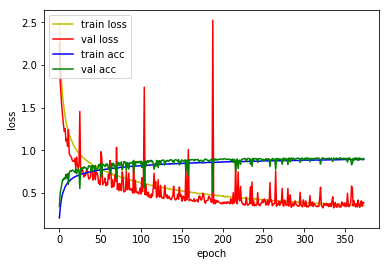

4815/4815 [==============================] - 2s 423us/sample - loss: 0.3943 - acc: 0.8843
Loss: 0.39425390006844746 Accuracy: 0.88431984

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3424 - acc: 0.2558
Epoch 00001: val_loss improved from inf to 2.08196, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_6_conv_checkpoint/001-2.0820.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 2.3423 - acc: 0.2558 - val_loss: 2.0820 - val_acc: 0.3687
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8076 - acc: 0.4308
Epoch 00002: val_loss improved from 2.08196 to 1.47446, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_6_conv_checkpoint/002-1.4745.hdf5
36805/36805 [==============================] - 31s 843us/sample - loss: 1.8077 - acc: 0.4308 - val_loss: 1.4745 - val_acc: 0.6124
Epoch 3/500
36800/36805 [====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6176 - acc: 0.8242
Epoch 00023: val_loss did not improve from 0.44957
36805/36805 [==============================] - 31s 838us/sample - loss: 0.6177 - acc: 0.8241 - val_loss: 0.4812 - val_acc: 0.8682
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5951 - acc: 0.8304
Epoch 00024: val_loss improved from 0.44957 to 0.43207, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_6_conv_checkpoint/024-0.4321.hdf5
36805/36805 [==============================] - 31s 840us/sample - loss: 0.5952 - acc: 0.8304 - val_loss: 0.4321 - val_acc: 0.8859
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5817 - acc: 0.8349
Epoch 00025: val_loss did not improve from 0.43207
36805/36805 [==============================] - 31s 832us/sample - loss: 0.5819 - acc: 0.8349 - val_loss: 0.4370 - val_acc: 0.8901
Epoch 26/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.4188 - acc: 0.8780
Epoch 00048: val_loss did not improve from 0.31197
36805/36805 [==============================] - 31s 838us/sample - loss: 0.4189 - acc: 0.8780 - val_loss: 0.3502 - val_acc: 0.8994
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4154 - acc: 0.8789
Epoch 00049: val_loss did not improve from 0.31197
36805/36805 [==============================] - 31s 837us/sample - loss: 0.4155 - acc: 0.8789 - val_loss: 0.3466 - val_acc: 0.9057
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4077 - acc: 0.8807
Epoch 00050: val_loss did not improve from 0.31197
36805/36805 [==============================] - 31s 835us/sample - loss: 0.4080 - acc: 0.8806 - val_loss: 0.3334 - val_acc: 0.9071
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4075 - acc: 0.8821
Epoch 00051: val_loss improved from 0.31197 to 0.30962, saving model to model/chec

36800/36805 [============================>.] - ETA: 0s - loss: 0.3350 - acc: 0.9020
Epoch 00075: val_loss did not improve from 0.26599
36805/36805 [==============================] - 31s 837us/sample - loss: 0.3350 - acc: 0.9020 - val_loss: 0.2752 - val_acc: 0.9276
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3307 - acc: 0.9026
Epoch 00076: val_loss improved from 0.26599 to 0.25747, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_6_conv_checkpoint/076-0.2575.hdf5
36805/36805 [==============================] - 31s 843us/sample - loss: 0.3308 - acc: 0.9025 - val_loss: 0.2575 - val_acc: 0.9327
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3266 - acc: 0.9025
Epoch 00077: val_loss did not improve from 0.25747
36805/36805 [==============================] - 31s 853us/sample - loss: 0.3266 - acc: 0.9025 - val_loss: 0.2665 - val_acc: 0.9262
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2753 - acc: 0.9177
Epoch 00103: val_loss did not improve from 0.23289
36805/36805 [==============================] - 31s 837us/sample - loss: 0.2753 - acc: 0.9177 - val_loss: 0.2396 - val_acc: 0.9371
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2775 - acc: 0.9177
Epoch 00104: val_loss did not improve from 0.23289
36805/36805 [==============================] - 31s 836us/sample - loss: 0.2778 - acc: 0.9177 - val_loss: 0.2634 - val_acc: 0.9278
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2764 - acc: 0.9177
Epoch 00105: val_loss did not improve from 0.23289
36805/36805 [==============================] - 31s 835us/sample - loss: 0.2767 - acc: 0.9177 - val_loss: 0.2609 - val_acc: 0.9327
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2731 - acc: 0.9193
Epoch 00106: val_loss did not improve from 0.23289
36805/36805 [=

Epoch 132/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2383 - acc: 0.9284
Epoch 00132: val_loss did not improve from 0.22928
36805/36805 [==============================] - 31s 833us/sample - loss: 0.2384 - acc: 0.9284 - val_loss: 0.2566 - val_acc: 0.9322
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2374 - acc: 0.9286
Epoch 00133: val_loss did not improve from 0.22928
36805/36805 [==============================] - 31s 833us/sample - loss: 0.2375 - acc: 0.9286 - val_loss: 0.2380 - val_acc: 0.9359
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2344 - acc: 0.9299
Epoch 00134: val_loss improved from 0.22928 to 0.22832, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_6_conv_checkpoint/134-0.2283.hdf5
36805/36805 [==============================] - 31s 837us/sample - loss: 0.2347 - acc: 0.9298 - val_loss: 0.2283 - val_acc: 0.9378
Epoch 135/500
36800/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9382
Epoch 00160: val_loss did not improve from 0.21081
36805/36805 [==============================] - 31s 834us/sample - loss: 0.2102 - acc: 0.9382 - val_loss: 0.2547 - val_acc: 0.9338
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2099 - acc: 0.9368
Epoch 00161: val_loss did not improve from 0.21081
36805/36805 [==============================] - 31s 833us/sample - loss: 0.2100 - acc: 0.9368 - val_loss: 0.2809 - val_acc: 0.9206
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2068 - acc: 0.9372
Epoch 00162: val_loss did not improve from 0.21081
36805/36805 [==============================] - 31s 836us/sample - loss: 0.2070 - acc: 0.9372 - val_loss: 0.2576 - val_acc: 0.9320
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2059 - acc: 0.9376
Epoch 00163: val_loss did not improve from 0.21081
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1826 - acc: 0.9451
Epoch 00189: val_loss did not improve from 0.20596
36805/36805 [==============================] - 31s 831us/sample - loss: 0.1826 - acc: 0.9451 - val_loss: 0.2194 - val_acc: 0.9411
Epoch 190/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1814 - acc: 0.9448
Epoch 00190: val_loss did not improve from 0.20596
36805/36805 [==============================] - 31s 831us/sample - loss: 0.1814 - acc: 0.9448 - val_loss: 0.2320 - val_acc: 0.9401
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1883 - acc: 0.9438
Epoch 00191: val_loss did not improve from 0.20596
36805/36805 [==============================] - 31s 834us/sample - loss: 0.1883 - acc: 0.9438 - val_loss: 0.2435 - val_acc: 0.9341
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1881 - acc: 0.9432
Epoch 00192: val_loss did not improve from 0.20596
36805/36805 [===============


1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_6_conv Model


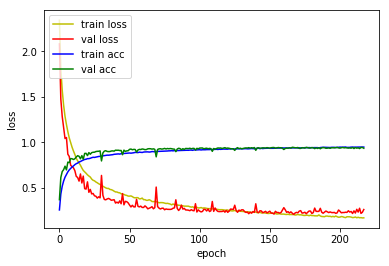

4815/4815 [==============================] - 2s 451us/sample - loss: 0.2416 - acc: 0.9269
Loss: 0.24161738423419765 Accuracy: 0.92689514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2312 - acc: 0.2940
Epoch 00001: val_loss improved from inf to 1.80404, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_7_conv_checkpoint/001-1.8040.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.2312 - acc: 0.2940 - val_loss: 1.8040 - val_acc: 0.4708
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5816 - acc: 0.5060
Epoch 00002: val_loss improved from 1.80404 to 1.16131, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_7_conv_checkpoint/002-1.1613.hdf5
36805/36805 [==============================] - 32s 869us/sample - loss: 1.5817 - acc: 0.5060 - val_loss: 1.1613 - val_acc: 0.6918
Epoch 3/500
36800/36805 [====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3315 - acc: 0.9038
Epoch 00023: val_loss did not improve from 0.24156
36805/36805 [==============================] - 32s 862us/sample - loss: 0.3315 - acc: 0.9038 - val_loss: 0.2447 - val_acc: 0.9341
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3247 - acc: 0.9063
Epoch 00024: val_loss improved from 0.24156 to 0.22812, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_7_conv_checkpoint/024-0.2281.hdf5
36805/36805 [==============================] - 32s 865us/sample - loss: 0.3248 - acc: 0.9063 - val_loss: 0.2281 - val_acc: 0.9343
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.9061
Epoch 00025: val_loss improved from 0.22812 to 0.21098, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_7_conv_checkpoint/025-0.2110.hdf5
36805/36805 [==============================] - 32s 864us/sample - loss: 0.3242 - acc: 0.9

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1996 - acc: 0.9414
Epoch 00050: val_loss did not improve from 0.16368
36805/36805 [==============================] - 32s 864us/sample - loss: 0.1995 - acc: 0.9414 - val_loss: 0.1815 - val_acc: 0.9443
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2026 - acc: 0.9396
Epoch 00051: val_loss did not improve from 0.16368
36805/36805 [==============================] - 32s 866us/sample - loss: 0.2026 - acc: 0.9396 - val_loss: 0.1890 - val_acc: 0.9476
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1972 - acc: 0.9409
Epoch 00052: val_loss did not improve from 0.16368
36805/36805 [==============================] - 32s 867us/sample - loss: 0.1974 - acc: 0.9409 - val_loss: 0.1666 - val_acc: 0.9513
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9406
Epoch 00053: val_loss did not improve from 0.16368
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.1408 - acc: 0.9561
Epoch 00077: val_loss did not improve from 0.14457
36805/36805 [==============================] - 32s 867us/sample - loss: 0.1408 - acc: 0.9561 - val_loss: 0.1741 - val_acc: 0.9488
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9563
Epoch 00078: val_loss did not improve from 0.14457
36805/36805 [==============================] - 32s 865us/sample - loss: 0.1404 - acc: 0.9562 - val_loss: 0.1476 - val_acc: 0.9560
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1482 - acc: 0.9561
Epoch 00079: val_loss did not improve from 0.14457
36805/36805 [==============================] - 32s 864us/sample - loss: 0.1483 - acc: 0.9561 - val_loss: 0.1585 - val_acc: 0.9529
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1377 - acc: 0.9584
Epoch 00080: val_loss did not improve from 0.14457
36805/36805 [==================

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1035 - acc: 0.9684
Epoch 00106: val_loss did not improve from 0.13959
36805/36805 [==============================] - 32s 866us/sample - loss: 0.1037 - acc: 0.9683 - val_loss: 0.1803 - val_acc: 0.9462
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9646
Epoch 00107: val_loss did not improve from 0.13959
36805/36805 [==============================] - 32s 870us/sample - loss: 0.1110 - acc: 0.9647 - val_loss: 0.1464 - val_acc: 0.9602
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9685
Epoch 00108: val_loss did not improve from 0.13959
36805/36805 [==============================] - 32s 868us/sample - loss: 0.1017 - acc: 0.9685 - val_loss: 0.1468 - val_acc: 0.9606
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9690
Epoch 00109: val_loss did not improve from 0.13959
36805/36805 [=

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0856 - acc: 0.9736
Epoch 00136: val_loss did not improve from 0.13959
36805/36805 [==============================] - 32s 861us/sample - loss: 0.0856 - acc: 0.9736 - val_loss: 0.1467 - val_acc: 0.9592
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0833 - acc: 0.9738
Epoch 00137: val_loss did not improve from 0.13959
36805/36805 [==============================] - 32s 863us/sample - loss: 0.0834 - acc: 0.9738 - val_loss: 0.1615 - val_acc: 0.9557
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9746
Epoch 00138: val_loss did not improve from 0.13959
36805/36805 [==============================] - 31s 854us/sample - loss: 0.0829 - acc: 0.9745 - val_loss: 0.1494 - val_acc: 0.9581
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9744
Epoch 00139: val_loss did not improve from 0.13959
36805/36805 [=

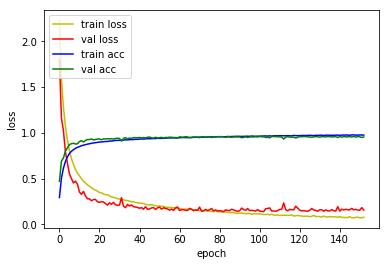

4815/4815 [==============================] - 2s 456us/sample - loss: 0.1874 - acc: 0.9448
Loss: 0.1874421004689495 Accuracy: 0.944756

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2440 - acc: 0.2992
Epoch 00001: val_loss improved from inf to 1.65167, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_8_conv_checkpoint/001-1.6517.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.2440 - acc: 0.2992 - val_loss: 1.6517 - val_acc: 0.5530
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3772 - acc: 0.5701
Epoch 00002: val_loss improved from 1.65167 to 0.85174, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_8_conv_checkpoint/002-0.8517.hdf5
36805/36805 [==============================] - 33s 904us/sample - loss: 1.3771 - acc: 0.5701 - val_loss: 0.8517 - val_acc: 0.7771
Epoch 3/500
36800/36805 [=======================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9421
Epoch 00023: val_loss did not improve from 0.15927
36805/36805 [==============================] - 33s 902us/sample - loss: 0.1982 - acc: 0.9422 - val_loss: 0.1613 - val_acc: 0.9518
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1924 - acc: 0.9432
Epoch 00024: val_loss improved from 0.15927 to 0.15333, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_8_conv_checkpoint/024-0.1533.hdf5
36805/36805 [==============================] - 33s 900us/sample - loss: 0.1924 - acc: 0.9432 - val_loss: 0.1533 - val_acc: 0.9536
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1861 - acc: 0.9435
Epoch 00025: val_loss did not improve from 0.15333
36805/36805 [==============================] - 33s 898us/sample - loss: 0.1861 - acc: 0.9434 - val_loss: 0.1702 - val_acc: 0.9481
Epoch 26/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0956 - acc: 0.9711
Epoch 00050: val_loss did not improve from 0.12906
36805/36805 [==============================] - 33s 887us/sample - loss: 0.0956 - acc: 0.9711 - val_loss: 0.1343 - val_acc: 0.9625
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0943 - acc: 0.9711
Epoch 00051: val_loss improved from 0.12906 to 0.12731, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_8_conv_checkpoint/051-0.1273.hdf5
36805/36805 [==============================] - 33s 897us/sample - loss: 0.0944 - acc: 0.9711 - val_loss: 0.1273 - val_acc: 0.9637
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0960 - acc: 0.9700
Epoch 00052: val_loss did not improve from 0.12731
36805/36805 [==============================] - 33s 910us/sample - loss: 0.0960 - acc: 0.9700 - val_loss: 0.1476 - val_acc: 0.9585
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9824
Epoch 00079: val_loss did not improve from 0.12731
36805/36805 [==============================] - 33s 900us/sample - loss: 0.0568 - acc: 0.9824 - val_loss: 0.1447 - val_acc: 0.9632
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9822
Epoch 00080: val_loss did not improve from 0.12731
36805/36805 [==============================] - 33s 901us/sample - loss: 0.0590 - acc: 0.9822 - val_loss: 0.1697 - val_acc: 0.9557
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9849
Epoch 00081: val_loss did not improve from 0.12731
36805/36805 [==============================] - 33s 900us/sample - loss: 0.0519 - acc: 0.9849 - val_loss: 0.1303 - val_acc: 0.9651
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0603 - acc: 0.9813
Epoch 00082: val_loss did not improve from 0.12731
36805/36805 [==================

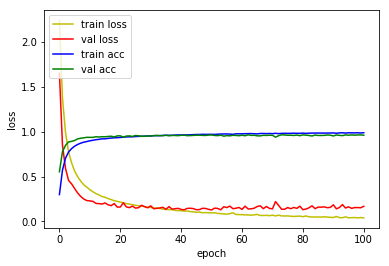

4815/4815 [==============================] - 2s 482us/sample - loss: 0.1820 - acc: 0.9477
Loss: 0.1819972254405512 Accuracy: 0.94766355



In [10]:
base = '1D_CNN_custom_multi_3_GAP_ch_32_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GAP_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 2s 519us/sample - loss: 0.6458 - acc: 0.8083
Loss: 0.6457661219227475 Accuracy: 0.80830735

1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activ

4815/4815 [==============================] - 3s 520us/sample - loss: 0.2416 - acc: 0.9269
Loss: 0.24161738423419765 Accuracy: 0.92689514

1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Acti

4815/4815 [==============================] - 3s 560us/sample - loss: 0.1820 - acc: 0.9477
Loss: 0.1819972254405512 Accuracy: 0.94766355


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 619us/sample - loss: 0.8193 - acc: 0.7466
Loss: 0.8192981995649922 Accuracy: 0.7466251

1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 3s 613us/sample - loss: 0.2766 - acc: 0.9184
Loss: 0.27655456238199 Accuracy: 0.9183801

1D_CNN_custom_multi_3_GAP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activati

4815/4815 [==============================] - 3s 693us/sample - loss: 0.2272 - acc: 0.9431
Loss: 0.22719424288228604 Accuracy: 0.9430945
